In [1]:
%cd ..

D:\Projects\Python\CC-NDP


# Numerical experiments

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [3]:
from contextlib import suppress

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

from src.classes import Result, ProblemData, FORMULATIONS

In [4]:
# For final compilation
mpl.rcParams["text.usetex"] = True
plt.style.use('grayscale')

## Solving simulated instances

In [5]:
experiments = pd.read_csv("data/instances/instances.csv", index_col="index")
experiments["name"] = experiments.apply(lambda row: ".".join(["inst", 
                                                              str(3 * row["num_nodes"]), 
                                                              str(row["num_layers"]),
                                                              str(row["num_scen"])]), axis=1)

experiments.head()

,num_nodes,num_layers,num_scen,name
index,,,,
1,12,1,25,inst.36.1.25
2,24,1,25,inst.72.1.25
3,36,1,25,inst.108.1.25
4,12,2,25,inst.36.2.25
5,24,2,25,inst.72.2.25


In [6]:
def make_perf_measures(df):
    df["run_time"] = df.result.apply(lambda res: res.run_time)
    df["num_iters"] = df.result.apply(lambda res: res.num_iters)
    df["objective"] = df.result.apply(lambda res: res.objective)

    return df

In [7]:
def make_re_dataframe(options):
    data = []
    results = []

    for experiment in experiments.index:
        data_loc = f"data/instances/{experiment}.json"
        data.append(dict(experiment=experiment, data=ProblemData.from_file(data_loc)))

        for relaxation in options:
            with suppress(FileNotFoundError):
                res = Result.from_file(f"data/results/{relaxation}/{experiment}.json")
                results.append(dict(experiment=experiment, relaxation=relaxation, result=res))
                
    results = pd.DataFrame.from_records(results).join(experiments, on="experiment")
    results = results.merge(pd.DataFrame.from_records(data), on="experiment")
    
    return make_perf_measures(results)

In [8]:
re_results = make_re_dataframe(FORMULATIONS)

In [9]:
re_results.experiment.groupby(re_results.relaxation).count()

relaxation
BB          5
FlowMIS    11
MIS        17
SNC        18
Name: experiment, dtype: int64

In [10]:
pvt = pd.pivot(index="experiment", columns="relaxation", values="run_time", data=re_results).reindex(range(1, 37))
pvt = pvt.join(experiments)
pvt = pvt.set_index("name").drop(["num_nodes", "num_layers", "num_scen"], axis=1)
pvt.style.highlight_min(subset=list(FORMULATIONS.keys()), axis=1)

,BB,FlowMIS,MIS,SNC
name,,,,
inst.36.1.25,nan,523.999242,256.905942,235.674081
inst.72.1.25,nan,nan,nan,nan
inst.108.1.25,nan,nan,nan,nan
inst.36.2.25,10205.821556,229.782964,123.534567,65.152387
inst.72.2.25,nan,nan,2722.264604,3256.387669
inst.108.2.25,nan,nan,nan,nan
inst.36.3.25,2185.879009,121.967533,20.614057,21.450550
inst.72.3.25,nan,nan,577.068111,528.312303
inst.108.3.25,nan,nan,nan,5121.340758


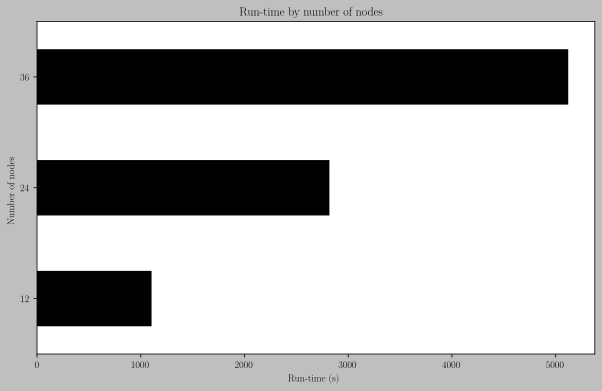

In [11]:
ax = re_results.run_time.groupby(re_results.num_nodes).mean().plot.barh(figsize=(10, 6))
ax.set_xlabel("Run-time (s)")
ax.set_ylabel("Number of nodes")
ax.set_title("Run-time by number of nodes");

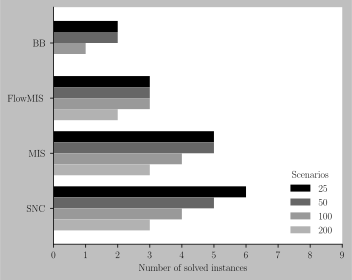

In [12]:
grouped = re_results.experiment.groupby([re_results.relaxation, re_results.num_scen])
ax = grouped.nunique().unstack(1).plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, 9])

ax.legend(title="Scenarios", frameon=False, loc="lower right")

plt.tight_layout();

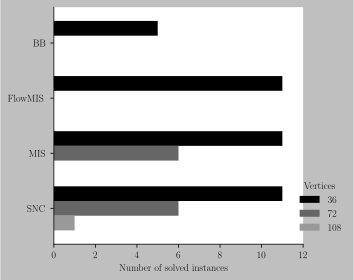

In [13]:
grouped = re_results.experiment.groupby([re_results.relaxation, re_results.num_nodes])
ax = grouped.nunique().unstack().plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, 12])

ax.legend(["36", "72", "108"], title="Vertices", frameon=False, bbox_to_anchor=(.95, 0.3))

plt.tight_layout();

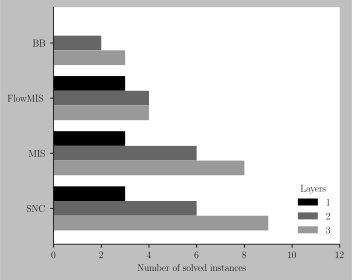

In [14]:
grouped = re_results.experiment.groupby([re_results.relaxation, re_results.num_layers])
ax = grouped.nunique().unstack().plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, 12])

ax.legend(title="Layers", frameon=False, loc="lower right")

plt.tight_layout();

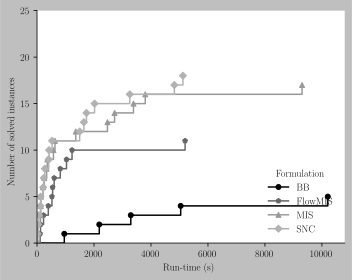

In [17]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_ylabel('Number of solved instances')
ax.set_xlabel('Run-time (s)')

for reformulation, style in zip(FORMULATIONS, ['o', 'p', '^', 'D', 's']):
    data = list(sorted(re_results[re_results.relaxation == reformulation].run_time))
    data.insert(0, 0)

    ax.step(data, np.arange(len(data)), where='post', label=reformulation, marker=style, markersize=5)

ax.legend(FORMULATIONS.keys(), title="Formulation", frameon=False, loc="lower right")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0, 25])
ax.set_xlim([0, 10_800])

plt.tight_layout();

## Valid inequalities